### setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as mcolors
import seaborn as sns
import stumpy

from collections import Counter 
from itertools import chain
from progiter import ProgIter
from scipy import interpolate
from scipy.signal import find_peaks, find_peaks_cwt
from scipy.stats import zscore, zmap
from sklearn.cluster import Birch
# from sklearn.preprocessing import MinMaxScaler, StandardScaler

sns.set(font_scale = 1.2)
np.set_printoptions(suppress=True)
pd.set_option("display.max_rows", 100)

In [2]:
def readDF(filepath_or_buffer, delimiter='\t', drop_labels=[0,1], axis='index'):
    '''
    filepath_or_buffer, delimiter, drop_labels and axis all have standard pandas syntax
    by default with axis='index' and drop_labels=[0,1], we drop first two rows. In GEO files they are used as a position counter, with windows size=50kb
    \\
    outputs percent missing values
    '''

    df = pd.read_csv(filepath_or_buffer=filepath_or_buffer, delimiter=delimiter)
    if drop_labels is not None:
        df = df.drop(labels=drop_labels, axis=axis) 
    df = df.reset_index(inplace=False, drop=True)
    print(f'{filepath_or_buffer} with {round(df.isna().sum().sum() / (df.shape[0] * df.shape[1]) * 100, ndigits=2)}% missing')

    return df

def getNAcols(input_df):
    '''
    returns columns, as Index object, that have any NAs
    '''
    return input_df.loc[:, input_df.isna().any()].columns.tolist()

def getChrCols(inp, chr_idx=1):
    '''
    inp can be a pandas df or a list or Index object
    for DF
        returns columns, as Index object, belonging to a given chr_idx.
    for list/index
        return elements of inp containing 'chrNUM.' 
    chr_idx can be in [1, 19]
    '''
    l = ['chr'+str(chr_idx)] # first column for each chr is just 'chr' and its index.
    s = 'chr'+str(chr_idx)+'.' 
    if isinstance(inp, pd.DataFrame):
        l.extend([x for x in inp.columns if s in x])
        return inp.loc[:, l].columns.tolist()
    else:
        return [x for x in inp if s in x]

def fillNAnearest(input_df_by_chr):
    '''
    fill missing with values from closest to the right cplumn
    if no columns to the right, take closest to the left
    >> so input chr by chr, and not all at once
    '''
    temp_df = input_df_by_chr.copy()
    temp_df = temp_df.fillna(method='bfill', axis='columns')
    temp_df = temp_df.fillna(method='ffill', axis='columns')
    return temp_df

def getBinID(input_df_genes_of_interest, chr_idx, is_gene=True):
    '''
    input df with kb-coordinates
    return df with bins using floor division
    '''
    temp_df = input_df_genes_of_interest.copy()
    out = temp_df.loc[ temp_df['chr'] == 'chr'+str(chr_idx), ['start','end'] ] // 50_000
    out['chr'] = 'chr'+str(chr_idx)
    out['num_bins'] = out['end'] - out['start'] + 1
    if is_gene:
        out['genename'] = temp_df['genename']
        return out
    else:
        return out


def getContArray(column_index):
    '''
    extract cont arrays from a list of column names
    return a list with cont indices as sublists
    
    1. get col names
    2. change to ints
    3. use ediff1d to get difference between consecutive entries (alternatively can use np.gradient)
    4. get indices where ediff1d is not 1, ie not a cont.array
    5. reshape to 1d array
    6. add +1 to fix array indexing (wtf)
    7. put all in np.split
    '''
    if isinstance(column_index, list):
        column_index = np.asarray(column_index, dtype=object)
    ar=column_index[np.asarray([len(x) for x in column_index])>5] # need for edge case like 'chr2' or 'chr11'
    
    return np.split(ar, np.argwhere( np.ediff1d( [int(x.replace('chr','')[2:].replace('.','')) for x in ar] ) != 1 )[:,0]+1)   

def bin_counter(input_row):
    '''
    input_row with bins (NOT kb coordinates
    return enumerated bins that can be used as column labels for original GEO df
    '''
    temp = np.arange(input_row['start'], input_row['end'], 1).tolist()
    temp.append(input_row['end'])
    return temp

def getS50(s_phase_array, step=0.1):
    ''' 
    inspired by https://github.com/CL-CHEN-Lab/RepliSeq/blob/master/R/calculateS50.R from https://www.nature.com/articles/s41467-019-13674-5#Sec12 
    return s50 value, that is a single descriptive statistic of a curve (like IC50 for dose-response, or LD50 for animals)
    s50 follows same logic as IC50/EC50, low s50 ~ early s-phase, high s50 ~ late s-phase 
    '''
    x = np.arange(0, len(s_phase_array))
    y = s_phase_array
    f = interpolate.interp1d(x, y)
    xnew = np.arange(0, len(y)-(1-step), step)
    ynew = f(xnew) 
    idx = np.searchsorted(np.cumsum(ynew), np.sum(ynew)/2)
    return idx/len(xnew)

def vizByGene(df_input, df_input_gene_bins, gene_name, window_size, fig_object, return_df=True):
    '''https://stackoverflow.com/a/65819334'''
    
    bins = df_input_gene_bins.loc[df_input_gene_bins['genename']==gene_name, 'bins'].tolist()[0]
    chromosome = df_input_gene_bins.loc[df_input_gene_bins['genename']==gene_name, 'chr'].tolist()[0]
    bins_before = list(range(bins[0]-window_size, bins[0], 1))
    bins_after = list(range(bins[-1]+1, bins[-1]+window_size+1, 1))
    bins = bins_before + bins + bins_after
    col_names=[chromosome+'.'+str(x) for x in bins]
    
    df_plot = df_input.loc[2:, col_names].copy() # assume first two rows are basepairs
    
    ax = fig_object.add_subplot(1,1,1)
    sns.heatmap(df_plot, vmin=df_plot.min().min(), vmax=df_plot.max().max(), cbar_kws={"orientation": "horizontal"}, yticklabels=False, xticklabels=True, ax=ax, cbar=False)
    if return_df:
        return fig_object, df_plot
    else: 
        return fig_object

def vizByBin(df_input, chr_idx, central_bin, window_size, step, fig_object, f_getChr=getChrCols, f_getS50=getS50, norm_by_window=True, return_df=False):
    '''
    todo: switch on tick labels
    
    for plotting
    df_input is a full df, without any NAs (i think?)
    chr_idx = chromosome idx used to filter the df_input
    central_bin is ID of a bin to be in the center
    window_size is how many bins around we plot
    step is used in imputation (for calculating s50), should divide 1 without remainder 
    fig_object is output of plt.figure(figsize=(width, height))
    f_getChrCols should be getChrCols, ie a function that is used to get names of columns for a chr_idx chromosome
    g_getS50 is a function used to calculated S50 from repliseq data
    norm_by_window when set True use min/max values from the slice of df. When set False use min/max from a full chromosome
    if return_df=True we also return the df used for plotting
    '''
    
    df_input_plot = df_input.loc[2:, f_getChr(df_input, chr_idx=chr_idx)].copy()
    bins_before = list(range(central_bin-window_size, central_bin, 1))
    bins_after = list(range(central_bin+1, central_bin+window_size+1, 1))
    bins = bins_before + [central_bin] + bins_after
    chromosome='chr'+str(chr_idx)
    col_names=[chromosome+'.'+str(x) for x in bins]
    df_plot = df_input_plot.loc[:, col_names].copy()
    
    ax1=fig_object.add_subplot(2,1,1)
    ax1.plot([x+0.5 for x in range(0, len(bins))], df_plot.apply(f_getS50,  axis=0, step=step), marker='.')
    ax1.axvline(x=window_size+0.5, label='bin'+str(central_bin)+' '+chromosome+' '+'window'+str(window_size), color='r')
    ax1.set_ylim((0,1))
    ax1.set_xlim(0, df_plot.shape[1])
    ax1.set_xticklabels([])
    ax1.set_ylabel('s50')
    ax1.legend(loc=0)
    
    if norm_by_window:
        vmin=df_plot.min().min()
        vmax=df_plot.max().max()
    else:
        vmin=df_input_plot.min().min()
        vmax=df_input_plot.max().max()
    
    ax2 = fig_object.add_subplot(2,1,2)
    # Q what do we take as min/max across the full chromosome (df_input_plot) or what we plot (df_plot)
    sns.heatmap(df_plot, vmin=vmin, vmax=vmax, cbar=False, yticklabels=np.arange(1,16,1), ax=ax2)
    ax2.set_yticklabels([])
    
    fig_object.subplots_adjust(hspace=0.00) 
    if return_df:
        return fig_object, df_plot
    else:
        return fig_object
    
def getSdiff(s_phase_array, step=0.25):
    ''' 
    calculate equivalent of IQR, but for interpolated (& rank-ordered) data. Step size is important for downstream analysis. Setting it to 0.1 makes ttr&breaks to be the most prominent feature
    '''
    x = np.arange(0, len(s_phase_array))
    y = s_phase_array
    f = interpolate.interp1d(x, y)
    xnew = np.arange(0, len(y)-(1-step), step)
    ynew = f(xnew) 
    idx_75 = np.searchsorted(np.cumsum(ynew), 3*np.sum(ynew)/4)
    idx_25 = np.searchsorted(np.cumsum(ynew), np.sum(ynew)/4)    
    return (idx_75-idx_25)/len(xnew)

def filterNoisy(iqr_array_by_chr, filter_Z_at=1.65, filter_bins_at=5, f_getCont=getContArray):
    '''
    input is an IQR array (output of getSdiff for a single chromosome)
    z-score transform iqr_array and filter at 1.96 (for 97.5%) or 1.65 (for 95%). Most s_diff values are from one side
    choose only areas that are >5 bins long as noise
    '''
    ar_z = zscore(iqr_array_by_chr)
    ar_z_idx = ar_z[ar_z>filter_Z_at].index
    return list(chain.from_iterable([x for x in f_getCont(ar_z_idx) if x.shape[0]>filter_bins_at]))

def getIZ_short(s50_series, plateau_size=[1,5], prominence=0.01, distance=7, return_plateau=False):
    '''
    apply to s50 values of a *single* chr
    for other params check find_peaks function in scipy
    '''
    peaks = find_peaks(1-s50_series, plateau_size=plateau_size, prominence=prominence, distance=distance) # find_peaks searches for peaks, but we need to find troughs in s50, so do 1-input
    if not return_plateau:
        return s50_series.index[peaks[0]]
    else:
        return s50_series.index[list(chain.from_iterable([list(range(x,y+1)) for x,y in zip(peaks[1]['left_edges'], peaks[1]['right_edges'])]))]
    
    
def getTTRsBreaks_short(s50_series, f_cont=getContArray, cutoff=5, bins_skip=None):
    '''
    apply to s50 values of a *single* chr
    bins_skip should be a list of lists with colnames to skip
    cutoff is used to filter away noisy parts
    '''
    
    if bins_skip is not None:
        skip=np.in1d(s50_series.index, np.unique(np.concatenate(bins_skip))) # marks idx to skip as True
        ar=s50_series.where(skip==False, -1)
        gr=np.gradient(ar)
    else:
        gr=np.gradient(s50_series.values)
    query_ar=np.logical_not(np.isclose(gr, np.repeat(0, repeats=len(s50_series)), atol=1e-3).astype(int)) * s50_series.values
    query=pd.Series(query_ar, index=s50_series.index)
    out=f_cont(query[query!=0].index)
    return [x for x in out if len(x)>cutoff]

def getCTR_short(s50_series, f_cont=getContArray, cutoff=4):
    '''
    apply to s50 values of a *single* chr
    cutoff is used to filter away noisy parts
    '''
    
    gr=np.gradient(s50_series.values)
    query_ar=np.isclose(gr, np.repeat(0, repeats=len(s50_series)), atol=1e-3).astype(int) * s50_series.values
    query=pd.Series(query_ar, index=s50_series.index)
    out=f_cont(query[query!=0].index)
    return [x for x in out if len(x)>cutoff]

def getTermination_short(s50_series, plateau_size=[1,2], prominence=0.05, distance=7, return_plateau=False):
    '''
    apply to s50 values of a *single* chr
    when return plateau=True, return all bins, else only the central
    for other params check find_peaks function in scipy
    '''
    peaks = find_peaks(s50_series, plateau_size=plateau_size, prominence=prominence, distance=distance) # find_peaks searches for peaks, but we need to find troughs in s50, so do 1-input
    if not return_plateau:
        return s50_series.index[peaks[0]]
    else:
        return s50_series.index[list(chain.from_iterable([list(range(x,y+1)) for x,y in zip(peaks[1]['left_edges'], peaks[1]['right_edges'])]))]

def vizS_any(df_input, s_s50, fig_object, bins=None, skip_idx=None, label=None):
    '''
    bins should be a dictionary, where key is type of features and value is a list of bins (colnames), skip_idx should contain noisy features that were found using filterNoisy
    '''
    ax1 = fig_object.add_subplot(2,1,1)
    ax1.plot(s_s50.values, label=label)
    if label is not None:
        if isinstance(label, list):
            pass
        handles,labels = ax1.get_legend_handles_labels()
    else:
        handles=[]
        labels=[]
    
    ax1.set_xlim(0, len(s_s50.values))
    ax1.set_ylim(0, 1)
    ax1.set_ylabel('S50', fontsize=20)
    #ax1.legend(loc=1, fontsize='large')
    ax1.set(xticklabels=[])
    
    if bins is not None:
        colors=mcolors.tab10(range(len(bins)))
        for (label,feature),c in zip(bins.items(), colors):
            for b in feature:
                ax1.axvline(np.where(s_s50.index == b)[0], lw=0.5, color=c)
            patch = mpatches.Patch(color=c)
            handles.append(patch)
            labels.append(label)
    
    if skip_idx is not None:
        for idx in skip_idx:
            ax1.axvline(np.where(s_s50.index == idx)[0], lw=0.2, color='purple')
        grey_patch = mpatches.Patch(color='purple')
        handles.append(grey_patch)
        labels.append('noise/NA')
        
    ax1.legend(handles, labels, bbox_to_anchor=(1,1))

            
    ax2=fig_object.add_subplot(2,1,2)
    sns.heatmap(df_input, cbar=False, ax=ax2)
    ax2.set_yticks([])
    
    fig_object.subplots_adjust(hspace=0)
    return fig_object

def getForksByChr(df_input_all_chr, chr_idx, use_cwt=True, peak_width=None, s50_cutoffs=None, f_getChrCols=getChrCols, f_getS50=getS50):
    '''
    *defunkt* function
    
    lets filter out areas with two peaks first (duplicate forks - they mess up things a little)
    we can use GMM fitting with one vs two components and then compare AIC/BIC or NLL in one-vs-two component scenario
    alternatively we can fit gaussian and try to find some cutoff value for e.g variance/st.dev. So gauss fit to two peak data will have a bigger st.dev
    there is also something called a dip test
    but it is whatever - i will use a function from numpy/scipy signal processing that finds peaks as parts of a graph where before&after y-vals are lower
    
    use_cwt - use wavelet transform if True, if False use on raw data. CWT works better with noise. Both use heuristic values for widths
    s50_cutoffs - we dont expect forks to be present when s50 for all 16 phases is >0.7. 
    This helps get rid of cases where there noise in the the data - so legit two peaks, but first is not that important
    increase of s50_cutoff interval should give more tentative hits
    '''
    df_input = df_input_all_chr.loc[2:, f_getChrCols(df_input_all_chr, chr_idx=chr_idx)].copy()
    if use_cwt:
        if peak_width is None:
            widths=4
        else:
            widths=peak_width
        # here we are looking for peaks using wavelet transform with a given peak_width of 4, found empirically lol. 
        cond1 = np.where(df_input\
                         .apply(find_peaks_cwt, widths=[widths])\
                         .apply(len)>1,
                         True,
                         False) 
    else:
        if peak_width is None:
            width=2.6
        else:
            width=peak_width
        # or using normal find_peaks with width between peaks, with val also found empirically
        cond1 = np.where(df_input\
                         .apply(find_peaks, width=width)\
                         .iloc[0,:]\
                         .apply(len)>1,
                         True,
                         False)
    # getS50 and assume for dupl forks S50~.5. This helps filter out all those values that are with epxerimental noise in the beginning/end, e.g. look at chr1.1
    ar = df_input.apply(f_getS50, step=0.25)
    if s50_cutoffs is None:
        cutoff1=0.1
        cutoff2=0.8
    else:
        cutoff1=s50_cutoffs[0]
        cutoff2=s50_cutoffs[1]
    cond2 = (ar>cutoff1) & (ar<cutoff2) 
    cond = cond1 & cond2 # logical AND   
    
    return df_input.loc[:, cond].columns
 
    
def sortLikePaper(df_input, return_sorted_idx=False):
    '''
    sorts like in Zhao et al 2020 -> 
    first sort by position (S-phase, 1-16) where max amount of replication occurs.
    second sort by how much replication occured in that position
    
    sorting is done on a single chromosome df
    returns sorted df
    '''
    # first sorting
    df_sorted1 = df_input.iloc[:, np.argsort(df_input.apply(np.argmax, axis='rows'))].copy()
    # second sorting. has to be done by position where max replication happens
    positions = set(np.sort(df_sorted1.apply(np.argmax, axis='rows')))
    holder=[]
    ar_sorted = df_sorted1.apply(np.argmax, axis='rows')
    for pos in positions:
        cols_idx = (ar_sorted == pos)
        df_temp = df_sorted1.loc[:, cols_idx]
        df_temp = df_temp.iloc[:, np.flip(np.argsort(df_temp.iloc[pos,:]))] # need to use flip here, coz np.argsort does not have choice of descending vs ascending
        holder.append(df_temp)
    if return_sorted_idx:
        return pd.concat(holder, axis='columns'), ar_sorted
    else:
        return pd.concat(holder, axis='columns')



def scalingto100range(input):
    a_scaled = np.zeros_like(input)
    for i in range(0, len(input)):
        for j in range (len(input[i])):
            a_scaled[i][j]=(input[i][j]/np.sum(input[:,j]))*100
    return (a_scaled)
    
def gaussfill2D(shape=(3,3), sigma=1):
    m,n = [(edge-1)/2 for edge in shape]
    y,x = np.ogrid[-m:m+1, -n:n+1]
    array = np.exp(-(x*x+y*y)/(2*sigma*sigma))
    array[array < np.finfo(array.dtype).eps * array.max()] = 0 # here we set a limit for floating point numbers
    sumarray = array.sum()
    if sumarray != 0:
        array /= sumarray
    return array

def gausssmoothing(rawcoveragematrix, shape=(3,3), sigma=1):
    avmatrix = np.zeros_like(rawcoveragematrix)

    paddedrawcoveragematrix = np.concatenate(
        (np.array([rawcoveragematrix[2,:] for i in range(int((shape[0]-1)/2))]),
         rawcoveragematrix,
         np.array([rawcoveragematrix[-1,:] for i in range(int((shape[0]-1)/2))])
        )
    )
    paddedrawcoveragematrix = np.pad(
        array=paddedrawcoveragematrix, 
        pad_width=((0,0), (int((shape[0]-1)/2), int((shape[0]-1)/2))),
        mode='constant',
        constant_values=np.nan
    )
    
    for i in ProgIter(range(int((shape[0]-1)/2), int(len(rawcoveragematrix)+(shape[0]-1)/2)), verbose=1):
        for j in range(int((shape[0]-1)/2), int(len(rawcoveragematrix[0])+(shape[0]-1)/2)):
            box=np.ma.masked_invalid(
                paddedrawcoveragematrix[int(i-(shape[0]-1)/2):int(i+(shape[0]-1)/2+1),
                                        int(j-(shape[0]-1)/2):int(j+(shape[0]-1)/2+1)]
            )
            
            avmatrix[int(i-(shape[0]-1)/2), int(j-(shape[0]-1)/2)] = np.nansum(np.multiply(box, gaussfill2D(shape=shape, sigma=sigma)))
    return (avmatrix)

### mNPC preprocessing

In [3]:
df = readDF('GSE137764_mNPC_Gaussiansmooth_scaled_autosome.mat.gz', drop_labels=None) #2.35% for only repliseq data

GSE137764_mNPC_Gaussiansmooth_scaled_autosome.mat.gz with 2.09% missing


In [4]:
# fillNA, chr by chr
df_filled = pd.DataFrame(columns=df.columns, index=df.index, data=np.zeros_like(df.values))

for chr_idx in range(1,20,1):
    temp_cols = getChrCols(df, chr_idx=chr_idx)
    df_filled.loc[:, temp_cols] = fillNAnearest(df.loc[:, temp_cols])
    
if len(getNAcols(df_filled)) == 0:
    print('no nans after filling')

no nans after filling


In [5]:
# reading in the genic coordinates of interest. deletions
soft_labels = readDF('hotspot_replication_annotation.txt', drop_labels=None)
soft_labels = soft_labels.loc[~(soft_labels['chr']=='chrX'), :]
soft_labels = soft_labels.sort_values(by='chr', key=lambda col: [int(x[3:]) for x in col] ).reset_index(drop=True, inplace=False)

# get bins for genes of interest

l = []
for chr_idx in range(1,20,1):
    out = getBinID(soft_labels, chr_idx=chr_idx)
    if out.isna().any().any():
        pass
    else:
        out['bins'] = out.apply(bin_counter, axis=1)
        l.append(out)
df_genes_bins = pd.concat(l)

hotspot_replication_annotation.txt with 0.8% missing


In [6]:
# reading in the genic coordinates of interest. insertions
soft_labels1 = readDF('hotspotInesrtionGeneCoordinates_bulat.txt', drop_labels=None)
soft_labels1 = soft_labels1.loc[~(soft_labels1['chr']=='chrX'), :]
soft_labels1 = soft_labels1.sort_values(by='chr', key=lambda col: [int(x[3:]) for x in col] ).reset_index(drop=True, inplace=False)

# get bins for genes of interest

l1 = []
for chr_idx in range(1,20,1):
    out = getBinID(soft_labels1, chr_idx=chr_idx)
    if out.isna().any().any():
        pass
    else:
        out['bins'] = out.apply(bin_counter, axis=1)
        l1.append(out)
df_genes_bins1 = pd.concat(l1)

hotspotInesrtionGeneCoordinates_bulat.txt with 0.0% missing


In [7]:
# gaussian smoothing
df_filled_smoothed = pd.DataFrame(columns=df_filled.columns, index=df_filled.index, data=np.zeros_like(df_filled.values))
df_filled_smoothed.iloc[2:,:] = gausssmoothing(df_filled.iloc[2:,:].values)
df_filled_smoothed.iloc[:2,:] = df_filled.iloc[:2,:]

# scaling to sum=100 for each column
df_filled_smoothed_scaled = pd.DataFrame(columns=df_filled_smoothed.columns, index=df_filled_smoothed.index, data=np.zeros_like(df_filled_smoothed.values))
df_filled_smoothed_scaled.iloc[2:,:] = scalingto100range(df_filled_smoothed.iloc[2:,:].values)
df_filled_smoothed_scaled.iloc[:2,:] = df_filled_smoothed.iloc[:2,:]

if len(getNAcols(df_filled_smoothed_scaled)) == 0:
    print('no nans after smoothing/scaling')

 16/16... rate=0.13 Hz, eta=0:00:00, total=0:02:04, wall=19:59 UTC


/tmp/ipykernel_26961/909348462.py:387: RuntimeWarning: invalid value encountered in double_scalars
  a_scaled[i][j]=(input[i][j]/np.sum(input[:,j]))*100


In [8]:
# more NaNs encountered 

df_filled_smoothed_scaled1 = pd.DataFrame(columns=df.columns, index=df.index, data=np.copy(df_filled_smoothed_scaled.values)) # use np.copy otherwise we backfill the original file
temp_cols = getChrCols(df_filled_smoothed_scaled, chr_idx=4) # we know it was chromosome 4
df_filled_smoothed_scaled1.loc[:, temp_cols] = fillNAnearest(df_filled_smoothed_scaled1.loc[:, temp_cols])
#df_filled_smoothed_scaled1.iloc[:2,:] = df_filled_smoothed_scaled.iloc[:2,:]
    
if len(getNAcols(df_filled_smoothed_scaled1)) == 0:
    print('no nans')

no nans


### sample viz (by gene and by bin, and all features)

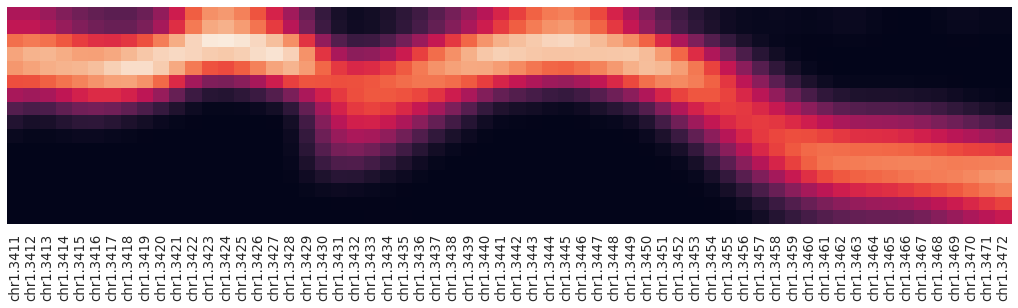

In [9]:
# viz by gene. just for demo really
fig = plt.figure(figsize=(18, 4))
fig = vizByGene(df_input=df_filled_smoothed_scaled1, df_input_gene_bins=df_genes_bins, gene_name='Copa', window_size=30, fig_object=fig, return_df=False)

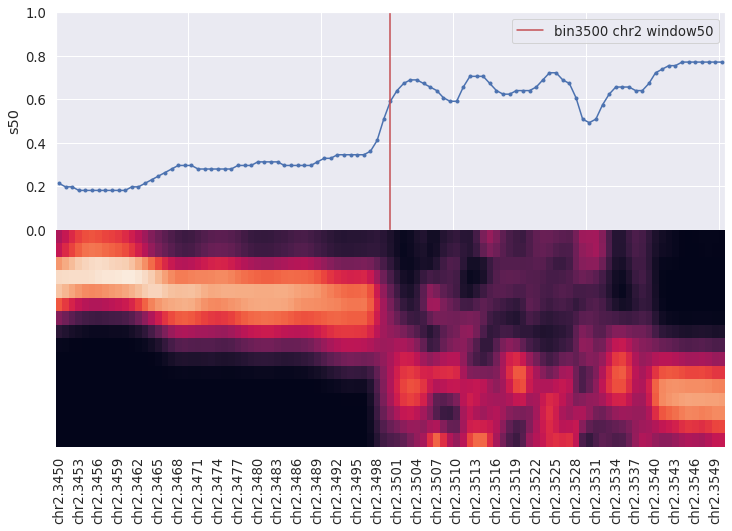

In [10]:
# viz by bin
# norm by window or by full chromosome (or by input df, not sure)
# if return_df=True df displayed is put out of size 2*window_size + central bin
fig_object = plt.figure(figsize=(12, 8))
fig, df_query = vizByBin(df_input=df_filled_smoothed_scaled1, chr_idx=2, central_bin=3500, window_size=50, step=.25, fig_object=fig_object, norm_by_window=True, return_df=True)

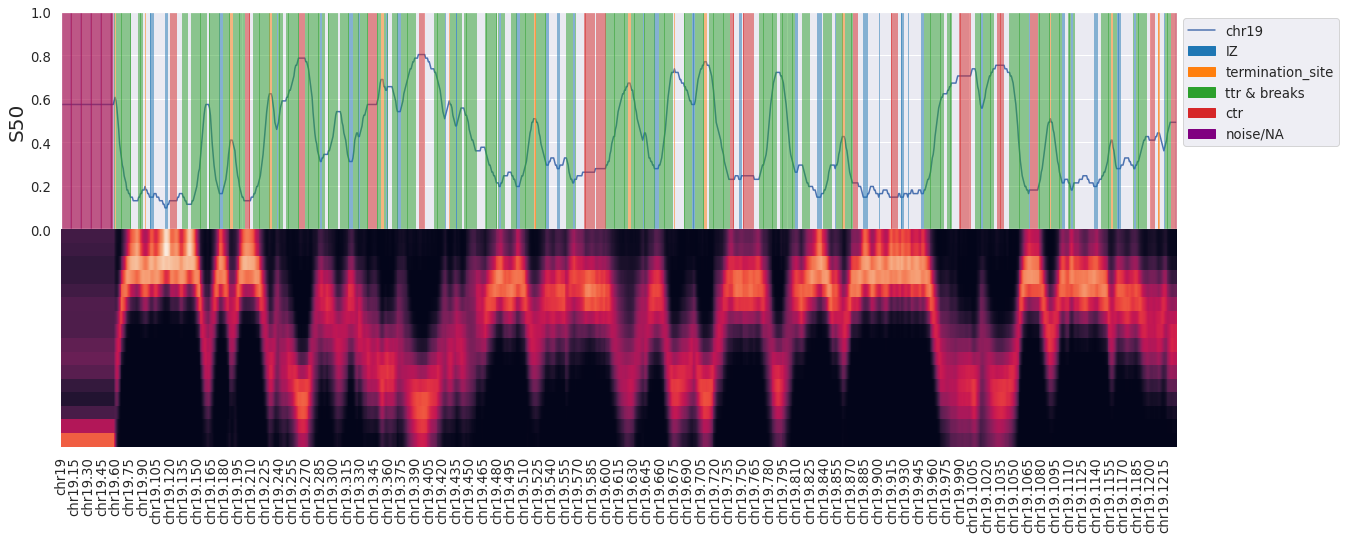

In [11]:
f=plt.figure(figsize=(20,8))
chr_idx=19

df_test = df_filled_smoothed_scaled1.loc[2:, getChrCols(df, chr_idx=chr_idx)].copy() # df for single chr. smoothed & imputed

s_s50 = df_test.apply(getS50, step=0.25) # s50 profile pd.series
s_sdiff = df_test.apply(getSdiff, step=0.25) # IQR profiles of s50 pd.series

l_bins_noisy = filterNoisy(s_sdiff, filter_Z_at=1.65, filter_bins_at=10) # Noisy cols
l_na = getNAcols(df.loc[2:, getChrCols(df, chr_idx=chr_idx)]) # NA cols

ar_skipping_bin = np.in1d(s_s50.index, np.concatenate([l_na, l_bins_noisy])) # binary
iz_bins = getIZ_short(s_s50.where(ar_skipping_bin==False, other=-1), prominence=0.01, return_plateau=True).tolist()
term_bins = getTermination_short(s_s50.where(ar_skipping_bin==False, other=-1), plateau_size=[1,3], prominence=0.05, return_plateau=True).tolist()

ttr_breaks_bins = list(chain.from_iterable(getTTRsBreaks_short(s_s50, bins_skip=[l_na, l_bins_noisy])))
ttr_breaks_bins = [x for x in ttr_breaks_bins if x not in term_bins+iz_bins]
ctr_bins = list(chain.from_iterable(getCTR_short(s_s50)))
ctr_bins = [x for x in ctr_bins if x not in term_bins+iz_bins+ttr_breaks_bins]

f=vizS_any(df_input=df_test, s_s50=s_s50, bins={'IZ':iz_bins, 'termination_site':term_bins, 'ttr & breaks':ttr_breaks_bins, 'ctr':ctr_bins}, fig_object=f, skip_idx=np.concatenate([l_na,l_bins_noisy]), label='chr'+str(chr_idx))

In [12]:

holder=dict()

for chr_idx in range(1,20):

    df_test = df_filled_smoothed_scaled1.loc[2:, getChrCols(df, chr_idx=chr_idx)].copy() # df for single chr. smoothed & imputed

    s_s50 = df_test.apply(getS50, step=0.25) # s50 profile pd.series
    s_sdiff = df_test.apply(getSdiff, step=0.25) # IQR profiles of s50 pd.series

    l_bins_noisy = filterNoisy(s_sdiff, filter_Z_at=1.65, filter_bins_at=10) # Noisy cols
    l_na = getNAcols(df.loc[2:, getChrCols(df, chr_idx=chr_idx)]) # NA cols
    ar_skipping_bin = np.in1d(s_s50.index, np.unique(np.concatenate([l_na, l_bins_noisy]))) # binary

    # IZ
    prior = list(set(l_na+l_bins_noisy))
    iz_bins = getIZ_short(s_s50.where(ar_skipping_bin==False, other=-1), prominence=0.01, return_plateau=True).tolist()
    iz_bins = [x for x in iz_bins if x not in prior]
    # terminations
    prior = list(set(prior+iz_bins))
    term_bins = getTermination_short(s_s50.where(ar_skipping_bin==False, other=-1), plateau_size=[1,3], prominence=0.05, return_plateau=True).tolist()
    term_bins = [x for x in term_bins if x not in prior]
    # ttr & breaks
    prior = list(set(prior+term_bins))    
    ttr_breaks_bins = list(chain.from_iterable(getTTRsBreaks_short(s_s50, bins_skip=[l_na, l_bins_noisy])))
    ttr_breaks_bins = [x for x in ttr_breaks_bins if x not in prior]
    # ctr
    prior = list(set(prior+ttr_breaks_bins))
    ctr_bins = list(chain.from_iterable(getCTR_short(s_s50)))
    ctr_bins = [x for x in ctr_bins if x not in prior]
    # other
    prior = list(set(prior+ctr_bins))    
    other = [x for x in s_s50.index if x not in prior]
        
    holder[str(chr_idx)]={'s50':s_s50, 'iz':iz_bins, 'termination':term_bins, 'ttr_breaks':ttr_breaks_bins, 'ctr':ctr_bins, 'noisy': list(set(l_na+l_bins_noisy)), 'other':other}


In [13]:
holder_frac={}
for chr_idx, val in holder.items():
    s=len(val["s50"])
    iz = round(100*len(val["iz"])/s, 2)
    termination = round(100*len(val["termination"])/s, 2)
    ttr_breaks = round(100*len(val["ttr_breaks"])/s, 2)
    ctr = round(100*len(val["ctr"])/s, 2)
    other = round(100*len(val["other"])/s, 2)
    noisy = round(100*len(val["noisy"])/s, 2)
    holder_frac[chr_idx] = {'iz':iz, 'termination':termination, 'ttr_breaks':ttr_breaks, 'ctr':ctr, 'other':other, 'noisy':noisy}


In [14]:
izs = [x['iz'] for x in holder_frac.values()]
terminations = [x['termination'] for x in holder_frac.values()]
ttr_breaks = [x['ttr_breaks'] for x in holder_frac.values()]
ctrs = [x['ctr'] for x in holder_frac.values()]
others = [x['other'] for x in holder_frac.values()]
noisy = [x['noisy'] for x in holder_frac.values()]

print([(label, round(np.mean(x),2) ) for x,label in zip([izs, terminations, ttr_breaks, ctrs, others, noisy], ['izs', 'terminations', 'ttr_breaks', 'ctrs', 'others', 'noisy']) ])

[('izs', 7.47), ('terminations', 2.14), ('ttr_breaks', 47.09), ('ctrs', 14.95), ('others', 23.41), ('noisy', 4.94)]


### genome vs exome

In [15]:
l_izs = list(chain.from_iterable([x["iz"] for x in holder.values()]))
l_terminations = list(chain.from_iterable([x["termination"] for x in holder.values()]))
l_ttr_breaks = list(chain.from_iterable([x["ttr_breaks"] for x in holder.values()]))
l_ctrs = list(chain.from_iterable([x["ctr"] for x in holder.values()]))
l_noisy = list(chain.from_iterable([x["noisy"] for x in holder.values()]))
l_other = list(chain.from_iterable([x["other"] for x in holder.values()]))

In [16]:
exome=pd.read_csv('exome_100bp_padding.bed', sep='\t', header=None)
exome.columns = ['chr','start','end']

In [17]:
exome = exome.loc[~(exome['chr']=='chrX'), :]
exome = exome.loc[~(exome['chr']=='chrY'), :]
exome = exome.loc[~(exome['chr']=='chrM'), :]
exome = exome.sort_values(by='chr', key=lambda col: [int(x[3:]) for x in col] ).reset_index(drop=True, inplace=False)


In [18]:
l2 = []
for chr_idx in range(1,20,1):
    out = getBinID(exome, chr_idx=chr_idx, is_gene=False)
    if out.isna().any().any():
        pass
    else:
        out['bins'] = out.apply(bin_counter, axis=1)
        l2.append(out)
df_genes_bins2 = pd.concat(l2)

In [19]:
exome_bins={}
for chr_idx in range(1,20):
    c = 'chr'+str(chr_idx)
    exome_bins[c]=list(set(chain.from_iterable(df_genes_bins2[df_genes_bins2['chr']==c].bins.values.tolist())))

In [20]:
l_all_exome=[]
idx=[]
for c, bins in exome_bins.items():
    str_bins=[c+'.'+str(subbin) for subbin in bins]   
    idx.append(c)
    verdict=[]
    for b in str_bins:
        if b in l_izs:
            verdict.append('IZ')
        elif b in l_terminations:
            verdict.append('termination')
        elif b in l_ttr_breaks:
            verdict.append('TTR or breakage')
        elif b in l_ctrs:
            verdict.append('CTR')
        elif b in l_noisy:
            verdict.append('noisy')
        else:
            verdict.append('other')
    l_all_exome.append(pd.DataFrame.from_dict(Counter(verdict), orient='index').T)
df_exome=pd.concat(l_all_exome)
df_exome.fillna(0, inplace=True)
df_exome.index=idx
df_exome.loc[:,'noisy'] = df_exome.loc[:,'noisy'].astype(int)

In [21]:
df_exome.to_csv('exome_counts_per_categ.csv', sep='\t')

### insertions

In [22]:
izs = list(chain.from_iterable([x["iz"] for x in holder.values()]))
terminations = list(chain.from_iterable([x["termination"] for x in holder.values()]))
ttr_breaks = list(chain.from_iterable([x["ttr_breaks"] for x in holder.values()]))
ctrs = list(chain.from_iterable([x["ctr"] for x in holder.values()]))
noisy = list(chain.from_iterable([x["noisy"] for x in holder.values()]))
other = list(chain.from_iterable([x["other"] for x in holder.values()]))

In [23]:
l_all=[]
for _,x in df_genes_bins.iterrows():
    
    bins=[x['chr']+'.'+str(subbin) for subbin in x['bins']]   
    verdict=[]
    for b in bins:
        if b in l_izs:
            verdict.append('IZ')
        elif b in l_terminations:
            verdict.append('termination')
        elif b in l_ttr_breaks:
            verdict.append('TTR or breakage')
        elif b in l_ctrs:
            verdict.append('CTR')
        elif b in l_noisy:
            verdict.append('noisy')
        else:
            verdict.append('other')
    l_all.append([x['genename'],
                  round(df_filled_smoothed_scaled1.loc[2:, bins].apply(getS50, step=0.1).mean(), 2),
                  soft_labels[soft_labels['genename']==x['genename']]['replication_feature'].values[0],
                  Counter(verdict).most_common()[0][0],Counter(verdict).most_common()[0][1],
                  Counter(verdict).most_common()[1:]]
                  )

In [24]:
df_genes_bins1[df_genes_bins1['genename']=='Ppp2r5a']

,start,end,chr,num_bins,genename,bins
0,3827,3827,chr1,1,Ppp2r5a,[3827]


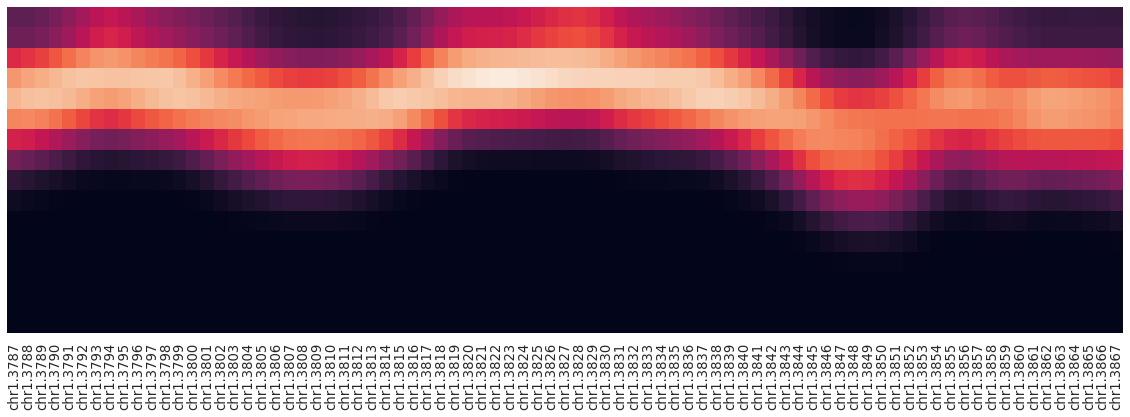

In [25]:
f=plt.figure(figsize=(20,6))
f = vizByGene(df_filled_smoothed_scaled1, df_genes_bins1, 'Ppp2r5a', 40, fig_object=f)

In [26]:
pd.DataFrame(l_all, columns=['genes','s50','soft_label','calc_most_common_label','most_common_label_count','other_labels&counts'])\
.to_csv('deletions_top50.csv', sep='\t', index=None)

In [27]:
l_all1=[]
for _,x in df_genes_bins1.iterrows():
    bins=[x['chr']+'.'+str(subbin) for subbin in x['bins']]   
    verdict=[]
    for b in bins:
        if b in l_izs:
            verdict.append('IZ')
        elif b in l_terminations:
            verdict.append('termination')
        elif b in l_ttr_breaks:
            verdict.append('TTR or breakage')
        elif b in l_ctrs:
            verdict.append('CTR')
        elif b in l_noisy:
            verdict.append('noisy')
        else:
            verdict.append('other')
    l_all1.append([x['genename'],
                   round(df_filled_smoothed_scaled1.loc[2:, bins].apply(getS50, step=0.1).mean(), 2),
                  Counter(verdict).most_common()[0][0],Counter(verdict).most_common()[0][1],
                  Counter(verdict).most_common()[1:]]
                  )

In [28]:
pd.DataFrame(l_all1, columns=['genes','s50','calc_most_common_label','most_common_label_count','other_labels&counts'])\
.to_csv('insertions_top50.csv', sep='\t', index=None)